# FNO for virtual damage sensor

In [1]:
# packages
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from pathlib import Path
from nopkit.data import load_damage_sensor_dataset
from nopkit.mask import MaskGenerator
from nopkit.plot import data_image, pred_plot, pred_anim, pred_voxel

# device = 'cuda'
device = 'cpu'

In [2]:
# load data
data_dir = Path("../data/damage_sensor")

train_loader, test_loaders, data_processor = load_damage_sensor_dataset(
    ramps_path=data_dir / "ramps_n500_res32.pt",
    damage_path=data_dir / "damage_n500_t175_res32.pt",
    defgrad_path=data_dir / "defgrad_n500_t175_res32.pt",
    elec_path=data_dir / "elec_n500_t175_res32.pt",
    masks_path=data_dir / "masks5_range4_17.pt",
    n_train=450, # 450 out of 500
    batch_size=50,
    test_batch_sizes=[50],
    test_resolutions=[32],
    encode_input=True,
    encode_output=True,
    # encoding="channel-wise",
    # channel_dim=1,
)
data_processor = data_processor.to(device)

c:\workspace\no_playground\neuralop-playground\nopkit_pkg\nopkit\data.py:199: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ramps = torch.load(ramps_path)      # shape (n_sa

Loaded RAMPs      -> ..\data\damage_sensor\ramps_n500_res32.pt,	(torch.Size([500, 32, 32]))
Loaded damage     -> ..\data\damage_sensor\damage_n500_t175_res32.pt,	(torch.Size([500, 32, 32, 175]))
Loaded defgrad    -> ..\data\damage_sensor\defgrad_n500_t175_res32.pt,	(torch.Size([500, 32, 32, 175]))
Loaded elec field -> ..\data\damage_sensor\elec_n500_t175_res32.pt,	(torch.Size([500, 32, 32, 175]))
Loaded masks      -> ..\data\damage_sensor\masks5_range4_17.pt,	(torch.Size([5, 32, 32]))
Loading total samples: 500, total masks: 5
Loading train db: 2250 samples, test db: 250 samples
Train input shape: torch.Size([2250, 3, 32, 32, 175]), Train output shape: torch.Size([2250, 3, 32, 32, 175])
Test input shape: torch.Size([250, 3, 32, 32, 175]), Test output shape: torch.Size([250, 3, 32, 32, 175])


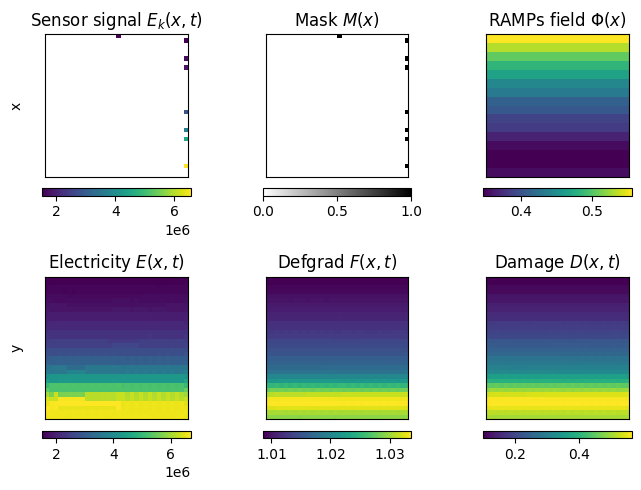

array([[<Axes: title={'center': 'Sensor signal $E_k(x, t)$'}>,
        <Axes: title={'center': 'Mask $M(x)$'}>,
        <Axes: title={'center': 'RAMPs field $\\Phi(x)$'}>],
       [<Axes: title={'center': 'Electricity $E(x, t)$'}>,
        <Axes: title={'center': 'Defgrad $F(x, t)$'}>,
        <Axes: title={'center': 'Damage $D(x, t)$'}>]], dtype=object)

In [3]:
# check train data
index = 5
x = train_loader.dataset[index]['x']
y = train_loader.dataset[index]['y']
data_image(x, y, t=174, show_colorbar=True)

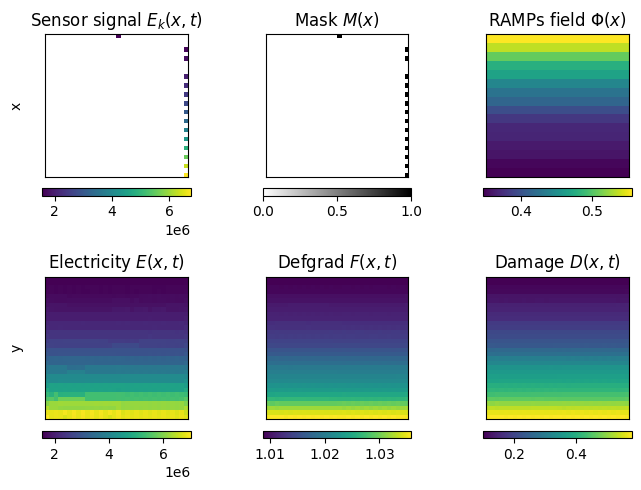

array([[<Axes: title={'center': 'Sensor signal $E_k(x, t)$'}>,
        <Axes: title={'center': 'Mask $M(x)$'}>,
        <Axes: title={'center': 'RAMPs field $\\Phi(x)$'}>],
       [<Axes: title={'center': 'Electricity $E(x, t)$'}>,
        <Axes: title={'center': 'Defgrad $F(x, t)$'}>,
        <Axes: title={'center': 'Damage $D(x, t)$'}>]], dtype=object)

In [4]:
# check test data
index = 49
x = test_loaders[32].dataset[index]['x']
y = test_loaders[32].dataset[index]['y']
data_image(x, y, t=174, show_colorbar=True)

In [4]:
# config model
model = FNO(
    n_modes=(8,8,10),
    in_channels=3,
    out_channels=3,
    hidden_channels=64,
    n_layers=4,
    projection_channel_ratio=2,
    positional_embedding = 'grid'
)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 12634435 parameters.


In [5]:
epochs=100
learning_rate=2e-5
scheduler_step=100
scheduler_gamma=0.5

# training setup
optimizer = AdamW(
    model.parameters(),
    lr=learning_rate, # learning rate
    weight_decay=1e-4
)

# use StepLR scheduler
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=scheduler_step, gamma=scheduler_gamma
)

# losses setup
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss # use H1 loss
eval_losses = {'h1': h1loss, 'l2':l2loss}

print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()



### MODEL ###
 FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([64, 64, 8, 8, 6]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
          (1): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(6, 128, kernel_size=(1,), stride=(1,))
      (1): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (1): Conv1d

In [3]:
# %%capture out
trainer = Trainer(
    model=model,
    n_epochs=epochs,
    data_processor=data_processor,
    device=device,
    mixed_precision=False,
    eval_interval=1,
    log_output=False,
    use_distributed=False,
    verbose=True,
    wandb_log = False
)

# train
trainer.train(
    train_loader=train_loader,
    test_loaders=test_loaders,
    optimizer=optimizer,
    scheduler=scheduler,
    regularizer=False,
    training_loss=train_loss,
    eval_losses=eval_losses,
    save_every=1,
    save_dir="./ckpt/fno3d_masks5/"
)

NameError: name 'model' is not defined